In [ ]:
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import glob
import numpy as np

In [ ]:
basedir = r'/content/drive/MyDrive/Dataset Macem-macem/DataSet Covid19/Data'

In [ ]:
! pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/Dataset Macem-macem/DataSet Covid19/Data", output="/content/", seed=1337, ratio=(.7, .2, .1), group_prefix=None) # default values

Copying files: 200 files [01:51,  1.80 files/s]


In [ ]:
train_dir = '/content/train'
val_dir = '/content/val'
test_dir = '/content/test'

In [ ]:
train_datagen = ImageDataGenerator(
                rescale = 1/255,
                horizontal_flip=True,
                zoom_range=0.1,
                shear_range=0.1,
                fill_mode='nearest'
                )

test_datagen = ImageDataGenerator(
                rescale = 1/255
                )

val_datagen = ImageDataGenerator(
                rescale = 1/255,
                horizontal_flip=True,
                zoom_range = 0.1,
                shear_range=0.1,
                fill_mode='nearest'
                )

In [ ]:
image_width = 224
image_height = 224

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size = (image_width,image_height),
                    color_mode = 'rgb',
                    class_mode='binary',
                    batch_size=4,
                    interpolation='nearest'
                    )

val_generator = train_datagen.flow_from_directory(
                    val_dir,
                    target_size = (image_width,image_height),
                    color_mode = 'rgb',
                    class_mode='binary',
                    batch_size=4,
                    interpolation='nearest'
                    )

test_generator = test_datagen.flow_from_directory(
                  test_dir,
                  target_size=(image_width,image_height),
                  color_mode = 'rgb',
                  shuffle=False
                  )

Found 140 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [ ]:
bModel = Xception(include_top=False,weights='imagenet',input_tensor=Input(shape=(224,224,3)))
bModel.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
hModel = bModel.output
hModel = AveragePooling2D(pool_size=(4,4))(hModel)
hModel = Flatten()(hModel)
hModel = Dense(128,activation='relu')(hModel)
hModel = Dropout(0.5)(hModel)
hModel = Dense(1,activation='sigmoid')(hModel)

model = Model(bModel.input,hModel)

for layer in bModel.layers:
  layer.trainable=False

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [ ]:
INIT_LR = 1e-3
EPOCHS = 10
BATCH = 4

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("Compiling Starts")
R = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH,
    epochs=EPOCHS)

Compiling Starts


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
35/35 [==============================] - 34s 908ms/step - loss: 0.4211 - accuracy: 0.7731 - val_loss: 0.0240 - val_accuracy: 1.0000
Epoch 2/10
35/35 [==============================] - 31s 881ms/step - loss: 0.0404 - accuracy: 0.9890 - val_loss: 0.0212 - val_accuracy: 1.0000
Epoch 3/10
35/35 [==============================] - 31s 882ms/step - loss: 0.0635 - accuracy: 0.9767 - val_loss: 0.0438 - val_accuracy: 0.9750
Epoch 4/10
35/35 [==============================] - 31s 878ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.0277 - val_accuracy: 0.9750
Epoch 5/10
35/35 [==============================] - 31s 880ms/step - loss: 0.0144 - accuracy: 0.9980 - val_loss: 0.0504 - val_accuracy: 0.9750
Epoch 6/10
35/35 [==============================] - 31s 880ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0537 - val_accuracy: 0.9750
Epoch 7/10
35/35 [==============================] - 31s 883ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.0285 - val_accuracy: 0.9750

In [ ]:
model.save('Covid19Xception.h5')

In [ ]:
actual = test_generator.classes
actual

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [ ]:
predicted = model.predict(test_generator, verbose=1)

1/1 [==============================] - 4s 4s/step


In [ ]:
import pandas as pd
test_generator.reset
df = pd.DataFrame({
    'filename':test_generator.filenames,
    'predict2':predicted[:,0],
    'y':test_generator.classes
})

In [ ]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['y_pred'] = df['predict2']>0.5
df.y_pred = df.y_pred.astype(int)
df

,filename,predict2,y,y_pred
0,Covid/1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg,0.00000,0,0
1,Covid/446B2CB6-B572-40AB-B01F-1910CA07086A.jpeg,0.00000,0,0
2,Covid/6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg,0.00000,0,0
3,Covid/7AF6C1AF-D249-4BD2-8C26-449304105D03.jpeg,0.00000,0,0
4,Covid/ciaa199.pdf-001-b.png,0.00036,0,0
5,Covid/covid-19-pneumonia-12.jpg,0.00000,0,0
6,Covid/covid-19-pneumonia-14-PA.png,0.00006,0,0
7,Covid/covid-19-pneumonia-20.jpg,0.00030,0,0
8,Covid/covid-19-pneumonia-58-day-10.jpg,0.00097,0,0
9,Covid/covid-19-pneumonia-58-day-9.jpg,0.00057,0,0


In [ ]:
misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image from {} Validation images : {}'.format(test_generator.samples,misclassified['y'].count()))

Total misclassified image from 20 Validation images : 0


In [ ]:
#Prediction of test set
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

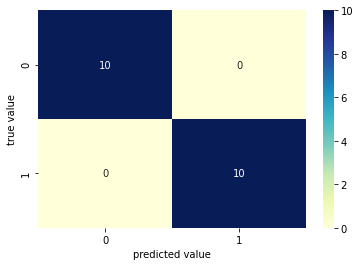

In [ ]:
conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

Prediction: Corona


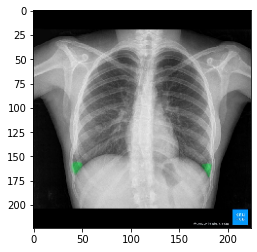

In [ ]:
import tensorflow as tf 
from keras.preprocessing import image
#from keras.models import load_model
from keras.applications.xception import preprocess_input
img = image.load_img('/content/image_2021-01-11_160014.png', target_size=(224, 224)) #insert a random covid-19 x-ray image
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
New_pred = np.argmax(classes, axis=1)
if New_pred==[1]:
  print('Prediction: Normal')
else:
  print('Prediction: Corona')